In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
df = pd.read_csv('Mall_Customers.csv', index_col='CustomerID')
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [4]:
df.shape

(200, 4)

In [7]:
#пропуски, типы
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [17]:
#немного оптимизации
df.iloc[:,1:4] = df[['Age','Annual Income (k$)', 'Spending Score (1-100)']].astype('int32')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int32 
 2   Annual Income (k$)      200 non-null    int32 
 3   Spending Score (1-100)  200 non-null    int32 
dtypes: int32(3), object(1)
memory usage: 5.5+ KB


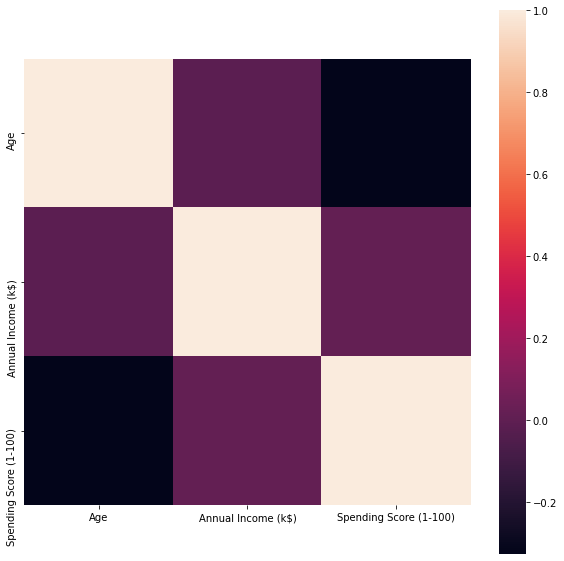

In [133]:
import seaborn as sns

plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), square=True);

In [88]:
#ярких линейных зависимостей нет

In [84]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


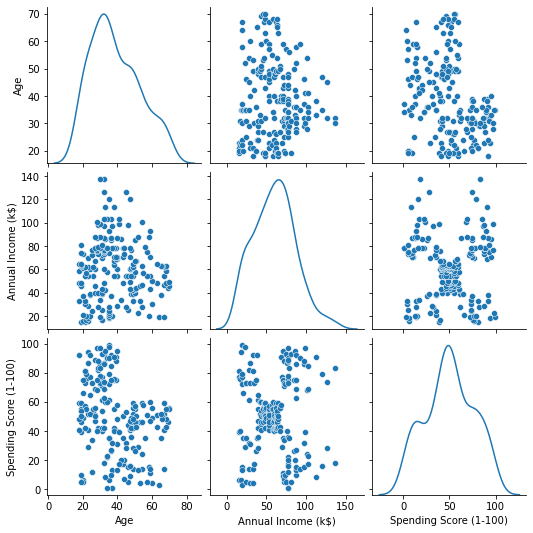

In [123]:
sns.pairplot(df, diag_kind='kde', diag_kws=dict(fill=False));

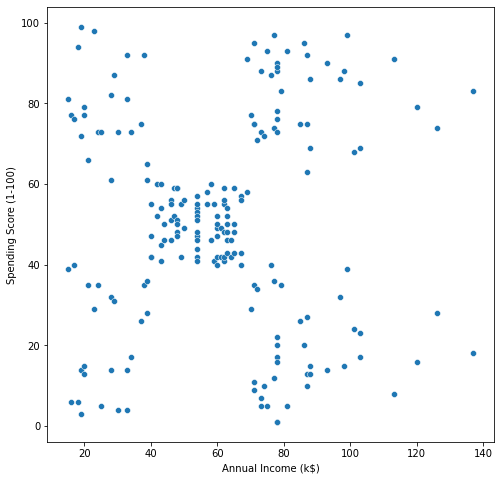

In [148]:
#на некоторых графиках можно различить группы
plt.subplots(figsize=(8,8))
sns.scatterplot(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)', data=df);

In [112]:
#посмотрим на распределения в зависимости от пола

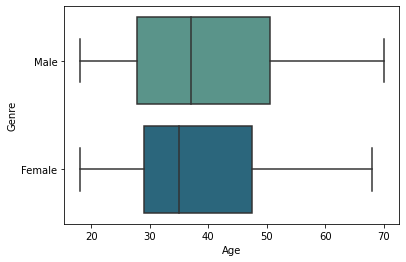

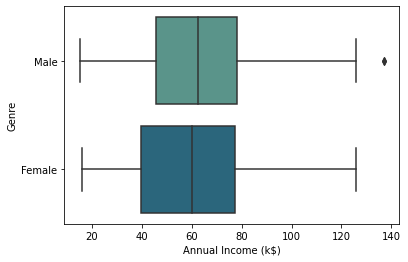

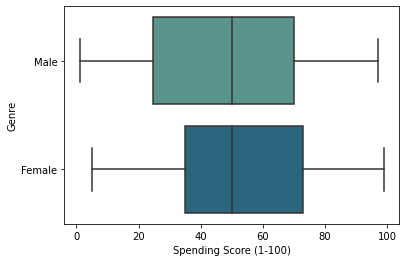

In [137]:
for c in df.columns[[1,2,3]]:
    sns.boxplot(x=c, y='Genre', data=df, palette='crest')
    plt.show()

In [120]:
# распределено между мужчинами и женщинами +- одинаково
# удалять мужчину с крупной покупкой не буду, максимальная сумма 137 при среднем 60, плюс маленький датасет
# не расцениваю как выброс

In [149]:
#preprocessing

In [179]:
#я не уверен, нужно ли конкретно в этом датасете проводить нормализацию, но проведу, хуже не будет
columns = list(df._get_numeric_data().columns)
x = df.loc[:, columns].values
x_norm = (x - x.mean(axis=0)) / x.std(axis=0)

In [180]:
from sklearn.cluster import KMeans

C:\Users\79276\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Площади')

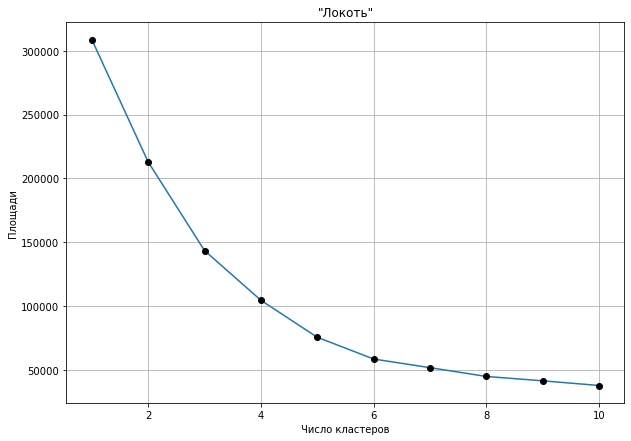

In [196]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
               random_state=123)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (10, 7)
plt.plot(range(1, 11), wcss)
plt.plot(range(1, 11), wcss, 'o',linewidth=20,color='black')
plt.grid()
plt.title('"Локоть"')
plt.xlabel('Число кластеров')
plt.ylabel('Площади')

In [195]:
#какого-то ярко выраженного "локтя" на графике нет, я возьму 5 кластеров
#которые были видны на скаттерплоте

Text(0.5, 1.0, 'Кластеры')

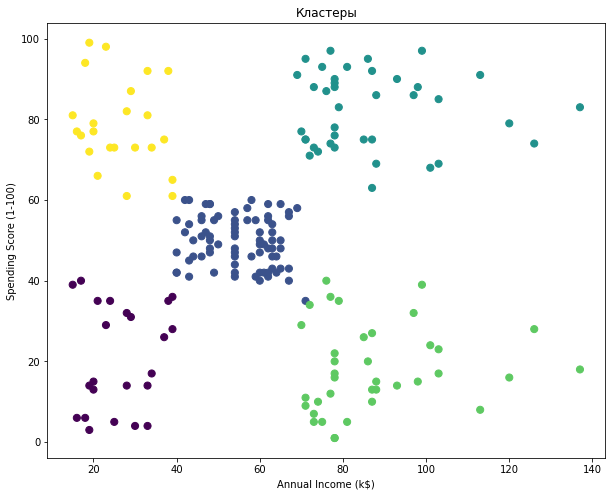

In [228]:
km = KMeans(n_clusters = 5, init = 'k-means++', random_state = 123)
km.fit(x)
plt.figure(figsize=(10,8))
plt.scatter(x = 'Annual Income (k$)', y = 'Spending Score (1-100)', data=df, c=km.labels_, s=50)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Кластеры')

In [223]:
df['Cluster'] = km.labels_
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
CustomerID,,,,,
1,Male,19,15,39,0
2,Male,21,15,81,4
3,Female,20,16,6,0
4,Female,23,16,77,4
5,Female,31,17,40,0


In [240]:
print(df.groupby('Cluster')['Annual Income (k$)'].mean().sort_values())
print(df.groupby('Cluster')['Spending Score (1-100)'].mean().sort_values())

Cluster
0    26.304348
4    26.304348
1    55.025641
2    86.538462
3    87.432432
Name: Annual Income (k$), dtype: float64
Cluster
3    18.189189
0    20.913043
1    49.692308
4    78.565217
2    82.128205
Name: Spending Score (1-100), dtype: float64


In [242]:
#rename clusters
cluster_names = {0:'мало трат, мало бонусов',
                 1:'середнячки',
                 2:'много трат, много бонусов',
                 3:'целевая',
                 4:'мало трат, много бонусов'}
df['Cluster'] = df['Cluster'].map(cluster_names)

In [244]:
#Теперь можно строить какую-либо стратегию

In [250]:
#посмотрим еще на распределения пола и возраста в целевой

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


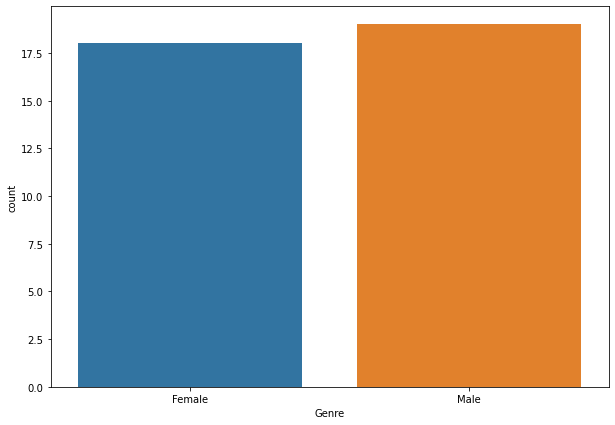

In [246]:
sns.countplot(df[df['Cluster']=='целевая']['Genre']);

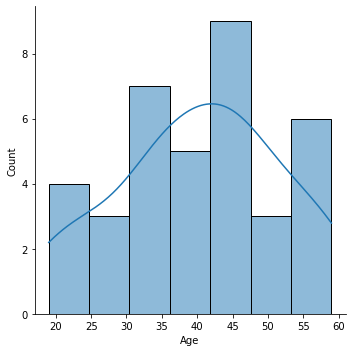

In [251]:
sns.displot(df[df['Cluster']=='целевая']['Age'], kde=True);

In [252]:
#иными словами, наши целевые клиенты в возрасте 35-50 лет с большими тратами
#и малыми расходами по карте лояльности
#без привзанности к полу